# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np

taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [2]:
taxi.isna().sum()

num_orders    0
dtype: int64

In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
taxi.index.unique()

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

## Analysis

In [6]:
#resample the data by one hr
import matplotlib.pyplot as plt

resampled_taxi = taxi.resample('1H').sum()

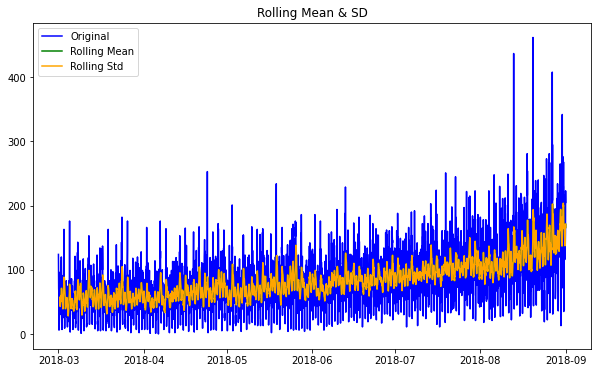

In [7]:
def test_stationary(resampled_taxi):
    rolmean = resampled_taxi.rolling(12).mean()
    rolstd = resampled_taxi.rolling(12).mean()
    
    plt.figure(figsize=(10,6))
    orig = plt.plot(resampled_taxi, color= 'blue', label= 'Original')
    mean = plt.plot(rolmean, color= 'green', label= 'Rolling Mean')
    std = plt.plot(rolstd, color= 'orange', label= 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & SD') 
    plt.show(block=False)

test_stationary(resampled_taxi)

In [8]:
resampled_taxi['hour'] = resampled_taxi.index.hour
resampled_taxi['month'] = resampled_taxi.index.month
resampled_taxi['day'] = resampled_taxi.index.day
resampled_taxi['dayofweek'] = resampled_taxi.index.dayofweek

hour
0     144.402174
1     104.364130
2     113.070652
3     102.021739
4      86.907609
5      42.630435
6      25.173913
7      29.271739
8      73.048913
9      88.831522
10     93.119565
11     82.489130
12     67.630435
13     71.173913
14     75.163043
15     87.945652
16    114.146739
17     92.722826
18     69.358696
19     77.336957
20     81.858696
21     95.211957
22     98.500000
23    109.766304
Name: num_orders, dtype: float64


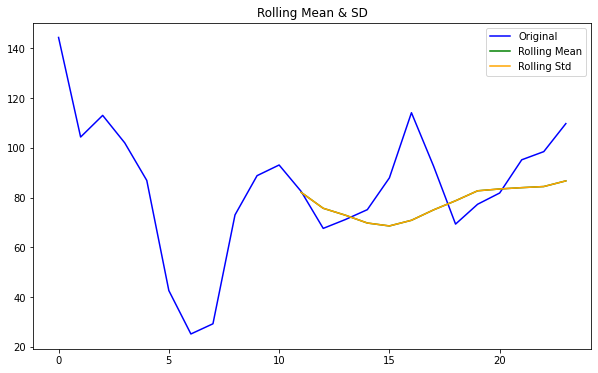

In [9]:
hour = resampled_taxi.groupby('hour')['num_orders'].mean()
print(hour)
test_stationary(hour)

From this hourly plot, the highest number of  rides are during 12 AM, 4 PM, 2 AM, and 11 PM. The lowest are during the 5 - 7 AM. 

dayofweek
0    90.246795
1    77.011218
2    83.754808
3    85.660494
4    91.140432
5    83.847756
6    78.991987
Name: num_orders, dtype: float64


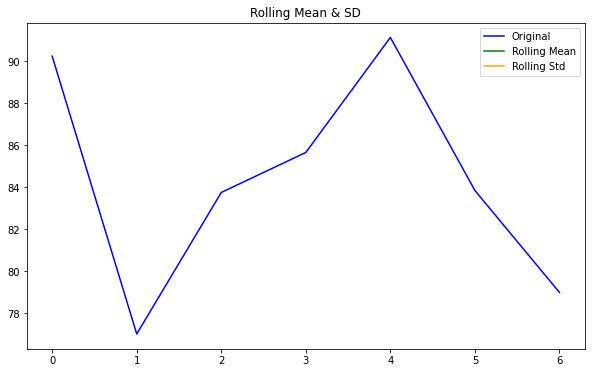

In [10]:
dayofweek = resampled_taxi.groupby('dayofweek')['num_orders'].mean()
print(dayofweek)
test_stationary(dayofweek)

The most rides are seen on Sunday and Thursday.

month
3     57.483871
4     63.804167
5     73.682796
6     83.202778
7    100.006720
8    127.651882
Name: num_orders, dtype: float64


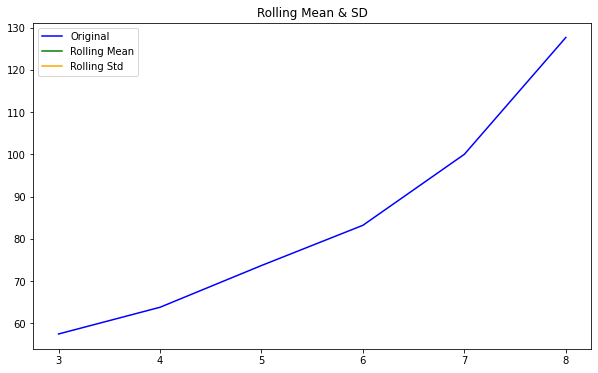

In [11]:
month = resampled_taxi.groupby('month')['num_orders'].mean()
print(month)
test_stationary(month)

There number of rides has a linear increase as each month passes by. 

# Decomposition

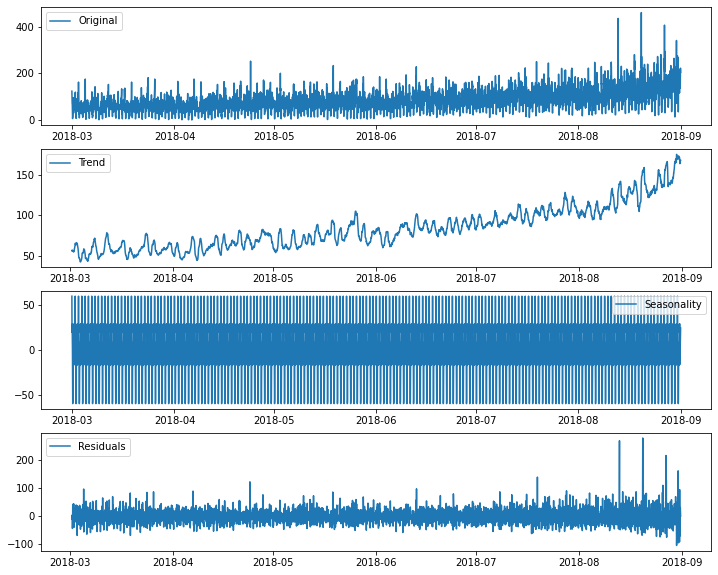

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(resampled_taxi['num_orders'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid 

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(resampled_taxi['num_orders'], label= 'Original')
plt.legend(loc= 'best')
plt.subplot(412) 
plt.plot(trend, label= 'Trend')
plt.legend(loc= 'best')
plt.subplot(413) 
plt.plot(seasonal, label= 'Seasonality')
plt.legend(loc= 'best')
plt.subplot(414) 
plt.plot(residual, label= 'Residuals')
plt.legend(loc= 'best')

plt.show()

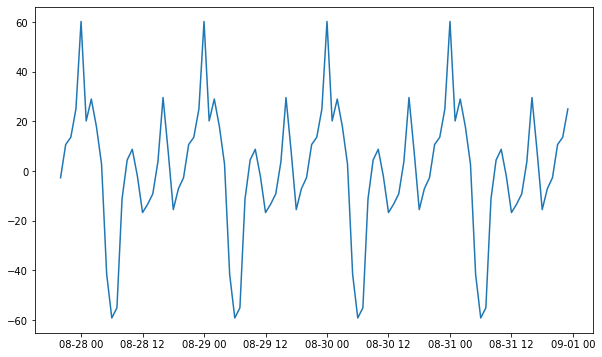

In [13]:
#a closer look at the seasonality plot 
plt.figure(figsize=(10,6))
plt.plot(seasonal[-100:], label= 'Seasonality')

There is a upward trend in the trend plot. There is a repeated pattern in the seasonality plot. For the residual plot, there is a spike of rides between august-september. From the trend, it looks there is a change in mean and repeating variation in the seasonality, this is a nonstationary process. 

## Training

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    
    for lag in range(1, max_lag+1): 
        resampled_taxi['lag_{}'.format(lag)] = resampled_taxi['num_orders'].shift(lag)
    
    resampled_taxi['rolling_mean'] = resampled_taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [15]:
make_features(resampled_taxi, 18,18)

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,8,31,4,207.0,217.0,197.0,116.0,133.0,...,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,159.166667
2018-08-31 20:00:00,154,20,8,31,4,136.0,207.0,217.0,197.0,116.0,...,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,155.944444
2018-08-31 21:00:00,159,21,8,31,4,154.0,136.0,207.0,217.0,197.0,...,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,151.722222


In [16]:
#split data into test and training set
from sklearn.model_selection import train_test_split
 
train, test = train_test_split(resampled_taxi, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
print(train.index.min(), train.index.max())
print(test.index.min(),train.index.max())

2018-03-01 18:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-13 13:00:00


In [18]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [19]:
#train Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

lnr = LinearRegression()
lnr_cv = cross_val_score(lnr, features_train, target_train, cv = tscv, scoring = 'neg_root_mean_squared_error')
print(-lnr_cv)
print('Average RMSE for Linear Regression:', -lnr_cv.mean())

[29.30959368 28.30777151 29.40783148 30.71506351 37.9971491 ]
Average RMSE for Linear Regression: 31.147481855665074


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

param = {'n_estimators': [10,50,10],
        'max_depth': [1,11]}
rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid = param, cv = tscv, scoring = 'neg_mean_squared_error')
rf_grid.fit(features_train, target_train)
best_grid = rf_grid.best_estimator_
predicted_values = best_grid.predict(features_train)
print('Best parameters for Random Forest:', best_grid)
print('RMSE for Random Forest:', mean_squared_error(target_train, predicted_values) ** 0.5)

Best parameters for Random Forest: RandomForestRegressor(max_depth=11, n_estimators=50)
RMSE for Random Forest: 13.063832594014276


In [21]:
from sklearn.tree import DecisionTreeRegressor
param = {'max_depth': [10,50,10]}

dt = DecisionTreeRegressor()
dt_grid = GridSearchCV(dt, param_grid = param, cv = tscv, scoring = 'neg_mean_squared_error')
dt_grid.fit(features_train, target_train)
best_grid_dt = dt_grid.best_estimator_
predicted_values_dt = best_grid_dt.predict(features_train)
print('Best parameters for Decision Tree:', best_grid_dt )
print('RMSE for Random Forest:', mean_squared_error(target_train, predicted_values_dt) ** 0.5)

Best parameters for Decision Tree: DecisionTreeRegressor(max_depth=10)
RMSE for Random Forest: 16.75679344556907


In [22]:
from catboost import CatBoostRegressor

param = {
    'learning_rate': [0.1, 0.05, 0.01],
    'depth': [4, 6, 8],
    'iterations': [100]
}

cat = CatBoostRegressor(random_state = 12345, loss_function = 'RMSE')
cat_grid = GridSearchCV(cat, param_grid = param, scoring='neg_mean_squared_error', cv=tscv, verbose=1)
cat_grid.fit(features_train, target_train)
best_params = cat_grid.best_params_
best_grid_cat = cat_grid.best_estimator_
predicted_values_cat = best_grid_cat.predict(features_train)
print('Best parameters for CatBooster:', best_params)
print("RMSE for CatBoost: ", mean_squared_error(target_train, predicted_values_cat) ** 0.5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 28.2702437	total: 48.5ms	remaining: 4.8s
1:	learn: 27.1629322	total: 50.6ms	remaining: 2.48s
2:	learn: 26.3576602	total: 52.6ms	remaining: 1.7s
3:	learn: 25.3033527	total: 54.7ms	remaining: 1.31s
4:	learn: 24.5590979	total: 56ms	remaining: 1.06s
5:	learn: 24.0175408	total: 57.4ms	remaining: 900ms
6:	learn: 23.3445935	total: 59.1ms	remaining: 786ms
7:	learn: 22.7911646	total: 60.7ms	remaining: 698ms
8:	learn: 22.1949300	total: 62.1ms	remaining: 628ms
9:	learn: 21.7328874	total: 63.5ms	remaining: 572ms
10:	learn: 21.2387775	total: 65ms	remaining: 526ms
11:	learn: 20.8977835	total: 66.4ms	remaining: 487ms
12:	learn: 20.6470413	total: 67.9ms	remaining: 454ms
13:	learn: 20.4113600	total: 69.6ms	remaining: 427ms
14:	learn: 20.1723507	total: 70.9ms	remaining: 402ms
15:	learn: 19.9555754	total: 72.3ms	remaining: 379ms
16:	learn: 19.5750321	total: 73.7ms	remaining: 360ms
17:	learn: 19.3084286	total: 75ms	remaining: 342ms
18:	

In [ ]:
## performing LightGBM model 
import lightgbm as lgb

param = {
    'boosting': 'gbdt',
    'max_depth': 10,
    'n_estimators': 100,
    'learning_rate': 0.05,
    'num_leaves': 50,
    'objective': 'regression'
}

lgb_reg = lgb.LGBMRegressor(**param)
lgb_cv = cross_val_score(lgb_reg, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
print(-lgb_cv)
print("Average RMSE score for LightGMB:", -lgb_cv.mean())

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [ ]:
data = {'Model': ['Linear Regression', 'Random Forest', 'Decision Tree', 'CatBoost', 'LightGBM'],
       'RMSE': [31.14 ,13.21 ,16.75 ,19.68 , 24.78]}
df_RMSE = pd.DataFrame(data)
df_RMSE = df_RMSE.set_index('Model')
df_RMSE

Random Forest results in the lowest RMSE at max_depth=11 and n_estimators=50. The highest RMSE is Linear Regression. 

## Testing

In [ ]:
rf = RandomForestRegressor(random_state=12345, max_depth =11, n_estimators=50)
rf.fit(features_train, target_train)
predicted_values = rf.predict(features_test)
print('RMSE for Random Forest:', mean_squared_error(target_test, predicted_values) ** 0.5)

In [ ]:
dt = DecisionTreeRegressor(random_state=12345, max_depth =10)
dt.fit(features_train, target_train)
predicted_values_dt = dt.predict(features_test)
print('RMSE for Decision Tree:', mean_squared_error(target_test, predicted_values_dt) ** 0.5)

In [ ]:
cat = CatBoostRegressor(random_state=12345, loss_function='RMSE', max_depth=8, learning_rate=0.1, iterations=100)
cat.fit(features_train, target_train)
predicted_values_cat=cat.predict(features_test)
print('RMSE for CatBooster:', mean_squared_error(target_test, predicted_values_cat) ** 0.5)

I tested the lowest 3 RMSE models from the training dataset. As expected, the Random Forest yields the lowest RMSE of 44.87, indicating the best model for this problem. It is also lower than the threshold of 48. 

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48